In [1]:
import numpy as np
import scipy
import scipy.stats as ss
import scipy.sparse
import networkx as nx
import sys
from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

#### matrix checks

In [7]:
import matrices
reload(matrices)
from matrices import *

n = 100
p = 0.7

np.random.seed(0)
A = make_adjacency_mat(n, p = p, dtype=np.float32)
np.random.seed(0)
A_sp = make_sparse_adj_mat(n, p = p, dtype=np.float32)
print('Sparse size MiB =', get_sparse_size(A_sp, 2))
print('Dense size MiB =', A.nbytes/(1024)**2)
# np.random.seed(0)
G = nx.gnp_random_graph(n, p, seed = 0)
E = nx.adj_matrix(G)
print('NX-sparse size MiB =', get_sparse_size(E, 2))
if n < 10:
    print(A, type(A))
    print(A_sp.toarray(), type(A_sp))
    print(E)

# print('ndarray == csr_matrix?', np.allclose(A, A_sp.toarray()))
# print('ndarray == nx_mat?', np.allclose(A, E.toarray().astype(np.float32)))
# print('is sparse symmetric?', np.allclose(A_sp.toarray(), A_sp.T.toarray()))
print('freq of 1s: %0.5f %0.5f %0.5f' % (np.mean(A), A_sp.mean(), E.mean()))
# A_sp.eliminate_zeros()
# print('After - Sparse size KiB =', get_sparse_size(A_sp))
# print(A/A.sum(1))

Sparse size MiB = 0.07962417602539062
Dense size MiB = 0.03814697265625
NX-sparse size MiB = 0.07928085327148438
freq of 1s: 0.69060 0.69240 0.68940


In [4]:
n = 2048
p = 10 / n

np.random.seed(0)
A = make_adjacency_mat(n, p = p, dtype=np.float32, column_stoch=True)
np.random.seed(0)
A_sp = make_sparse_adj_mat(n, p = p, dtype=np.float32, column_stoch=True)
print('type of sparse is', type(A_sp))
# print('Dense symmetric?', np.allclose(A, A.T))
# print('Sparse symmetric?', ((A - A.T)**2).sum() < 1e-10)

print('Column stochastic?', np.allclose(A.sum(axis = 0), np.ones(n)))
print('Sparse clolumn stochastic?', np.allclose(np.array(A_sp.sum(axis = 0))[0], np.ones(n)))

type of sparse is <class 'scipy.sparse.csr.csr_matrix'>
Column stochastic? True
Sparse clolumn stochastic? False


In [41]:
import descent_utils
reload(descent_utils)
from descent_utils import *

In [21]:
pow_n = 11
n = 2 ** pow_n
p = 10 / n
gamma = 1 / np.sqrt(n)

np.random.seed(0)
E_ = make_sparse_adj_mat(n, p = p, dtype=np.float32, column_stoch=True)
# list_k = [16, 32, 64, 128, 256, 512, 1024, 2048]
Ls = {k : get_L(make_group(n, k), E_, gamma) for k in 2 ** np.arange(0, pow_n + 1, 1) }#if k < 2 or k > 32}
print(Ls.keys())

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])


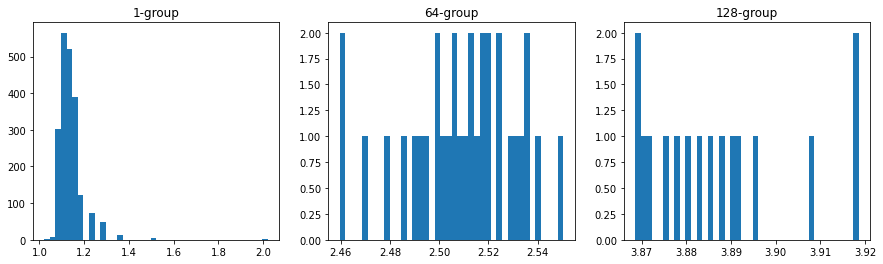

In [22]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title('1-group')
plt.hist(Ls[1], bins = 40)
plt.subplot(1,3,2)
plt.hist(Ls[64], bins = 40)
plt.title('64-group')
plt.subplot(1,3,3)
plt.hist(Ls[128], bins = 40)
plt.title('128-group')
plt.show()

In [62]:
# from tqdm import tqdm
def run_experiment(pow_n = 12, freq = 1, gamma = None, max_iter = 100, x0 = None, seed = 1, deter = False , alpha = 1, ignore_list = []):
    n = 2 ** pow_n
    p = 10 / n

    if gamma is None:
        gamma = 1 / np.sqrt(n)
        
    np.random.seed(seed)
    
    E_ = make_sparse_adj_mat(n, p = p, column_stoch=True)
    # list_k = [16, 32, 64, 128, 256, 512, 1024, 2048]
    domain = [i for i in range(0, pow_n, freq)]
    if domain[-1] != pow_n:
        domain += [pow_n]
    domain = np.array(domain)
    Ls = {k : get_L(make_group(n, k), E_, gamma) for k in 2 ** domain if k not in ignore_list}
    print(Ls.keys())
    
    logs = {'pow_n': pow_n, 'n' : n, 'gamma' : gamma, 'L' : Ls, 'E' : E_, 'a' : alpha}
    logs['strategy'] = 'Cyclic' if deter else 'Random'
    logs['x0'] = 'e * 1/\sqrt{n}' if x0 is None else 'random'
    
    if x0 is None:
        x0 = np.ones(n) / n
    
    dict_groups = {}
    for k in Ls.keys():
#         if k in ignore_list:
#             continue
        indices = make_group(n, k)

#         max_iter = 200
        np.random.seed(seed)
        dict_groups[k] = run_iters(x0, indices, E_, gamma, L = Ls[k], max_iter = max_iter, alpha = alpha, deter = deter)
    logs['loss'] = dict_groups
    
    return logs

def plot_results(log, figsize=(15, 9), end = 50):
    plt.figure(figsize=figsize)
    title = r'$%s, \alpha = %d, x_0 = %s, n = %d$' % (log['strategy'], log['a'], log['x0'], log['n'])
    plt.title(title)
    plt.xlabel(r'$n$, iteration')
    plt.ylabel(r'$\log(f(x_n))$, loss')
    for k in log['loss'].keys():
        
        plt.semilogy(log['loss'][k][:end], label=f'group size {k}' if k != log['n'] else 'full grad')
    plt.legend()
    x0 = 'r' if log['x0'] == 'random' else 'u'
    plt.savefig('./pics/%s.png' % (log['strategy'] + str(log['pow_n']) + x0 + str(log['a'])));

In [9]:
np.random.seed(0)
n = 12
x0 = np.random.randn(2 ** n)
rand_logs = {}
rand_logs[n] = run_experiment(pow_n = n, x0 = x0, seed = 0)
cycl_logs = {}
cycl_logs[n] = run_experiment(pow_n = n, Ls = rand_logs[n]['L'], x0 = x0, seed = 0, deter = True)

  0%|          | 0/100 [00:00<?, ?it/s]

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])


  0%|          | 0/100 [00:00<?, ?it/s]

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])


100%|██████████| 100/100 [00:00<00:00, 688.98it/s]


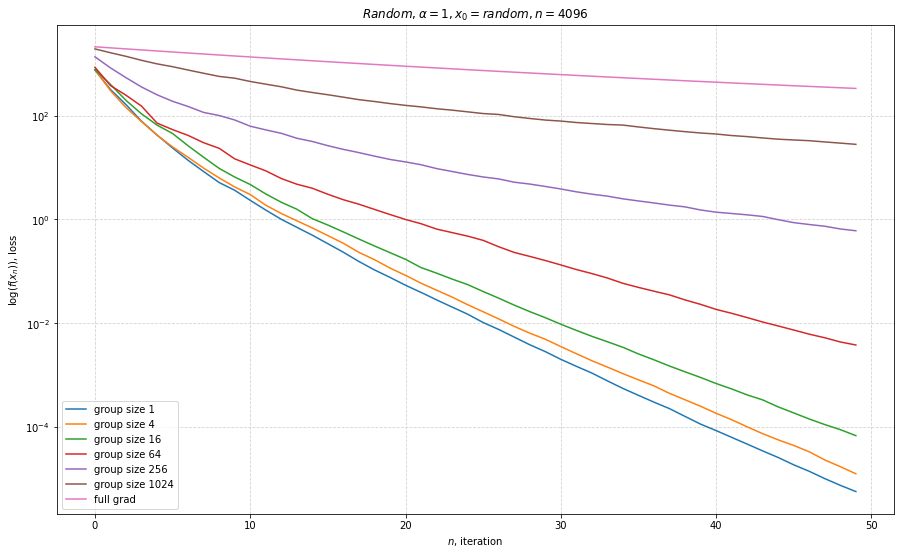

In [42]:
plot_results(rand_logs[n], step = 2)

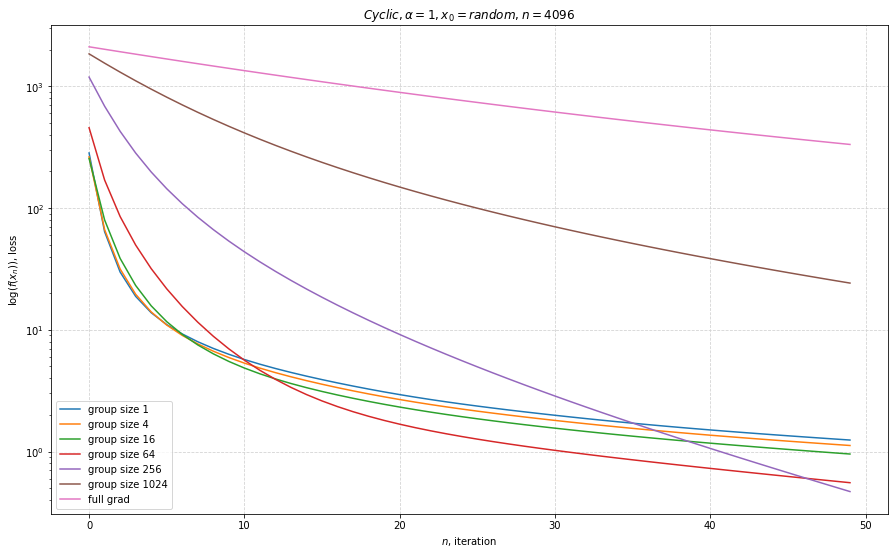

In [43]:
plot_results(cycl_logs[n], step = 2)

In [15]:
urand_logs = {}
urand_logs[n] = run_experiment(pow_n = n, Ls = rand_logs[n]['L'], seed = 0)
ucycl_logs = {}
ucycl_logs[n] = run_experiment(pow_n = n, Ls = rand_logs[n]['L'], seed = 0, deter = True)

  0%|          | 0/100 [00:00<?, ?it/s]

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])


  0%|          | 0/100 [00:00<?, ?it/s]

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])


100%|██████████| 100/100 [00:00<00:00, 704.29it/s]


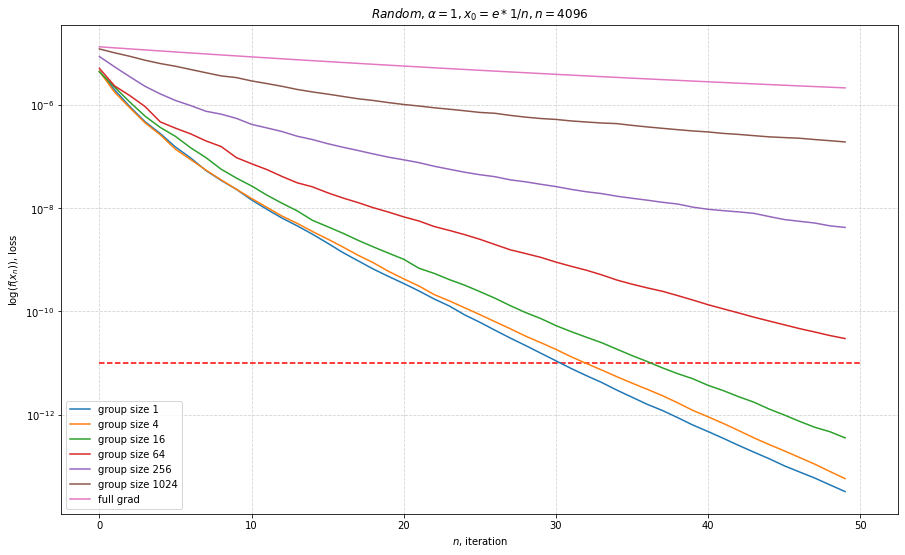

In [44]:
plot_results(urand_logs[n], step = 2)

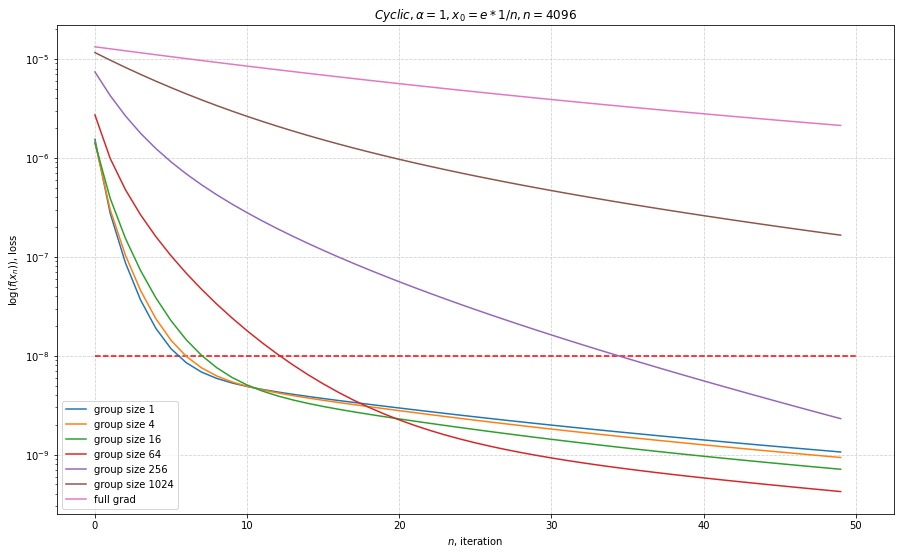

In [45]:
plot_results(ucycl_logs[n], step = 2)

In [37]:
np.random.seed(0)
n = 12
x0 = np.random.randn(2 ** n)
uni_logs = {}
uni_logs[n] = run_experiment(pow_n = n, x0 = x0, Ls = rand_logs[n]['L'], seed = 0, alpha = 0)

  0%|          | 0/100 [00:00<?, ?it/s]

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])


100%|██████████| 100/100 [00:00<00:00, 1142.38it/s]


In [38]:
uuni_logs = {}
uuni_logs[n] = run_experiment(pow_n = n, Ls = rand_logs[n]['L'], seed = 0, alpha = 0)

  0%|          | 0/100 [00:00<?, ?it/s]

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])


100%|██████████| 100/100 [00:00<00:00, 1093.20it/s]


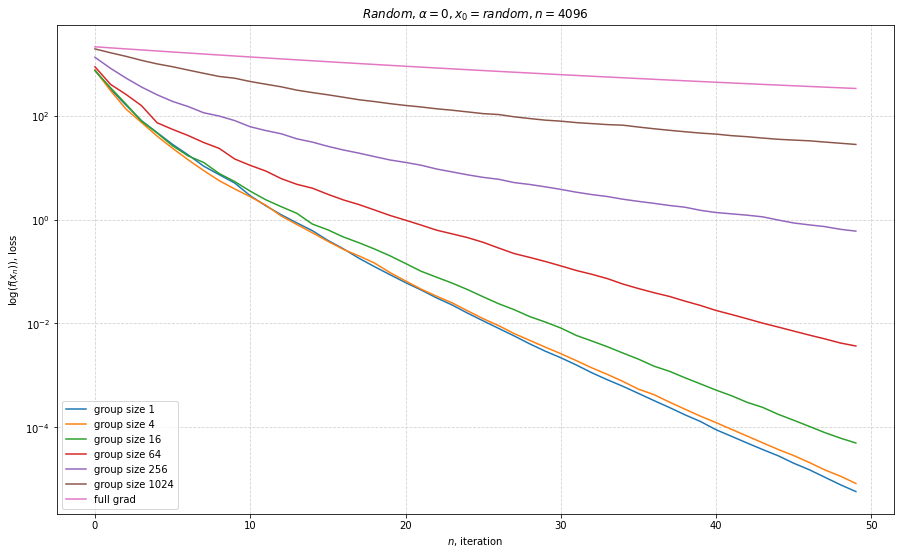

In [46]:
plot_results(uni_logs[n], step = 2)

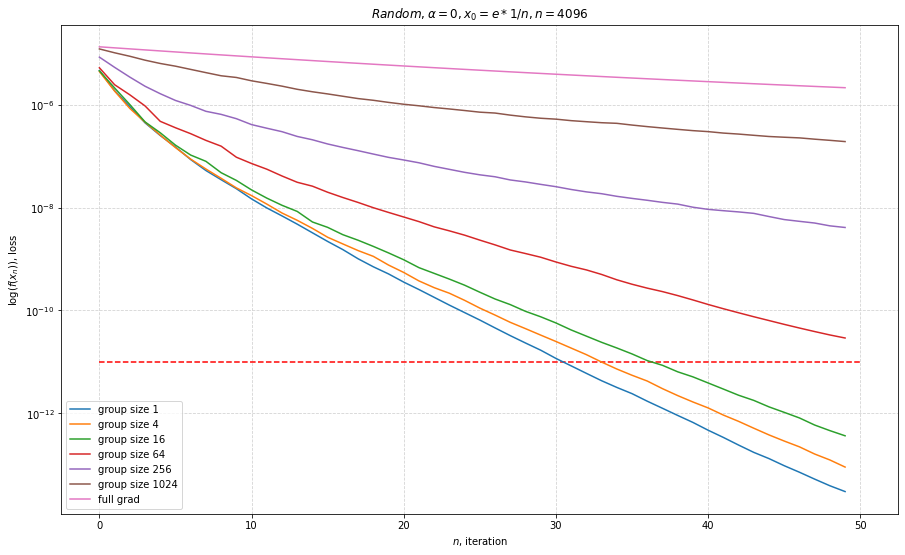

In [47]:
plot_results(uuni_logs[n], step = 2)

In [50]:
rand_logs.keys()

dict_keys([12])

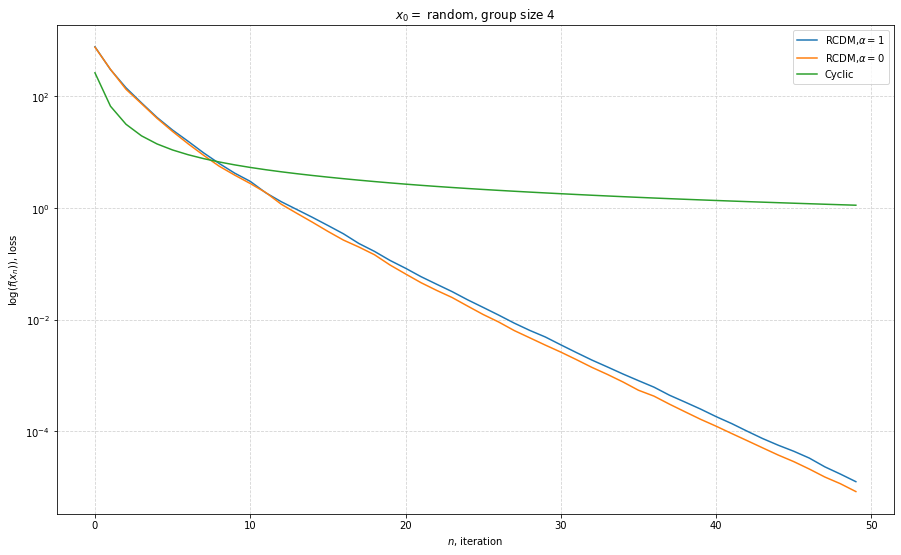

In [54]:
plt.figure(figsize=(15, 9))
plt.grid(color='lightgray',linestyle='--')
# title = r'$%s, \alpha = %d, x_0 = %s, n = %d$' % (log['strategy'], log['a'], log['x0'], log['n'])
plt.title(r'$x_0=$ random, group size 4')
plt.xlabel(r'$n$, iteration')
plt.ylabel(r'$\log(f(x_n))$, loss')
plt.semilogy(rand_logs[n]['loss'][4][:50], label=r'RCDM,$\alpha = 1$')
plt.semilogy(uni_logs[n]['loss'][4][:50], label=r'RCDM,$\alpha = 0$')
plt.semilogy(cycl_logs[n]['loss'][4][:50], label=r'Cyclic')
plt.legend()

# x0 = 'r' if log['x0'] == 'random' else 'u'

# plt.hlines(1e-11, 0, 50, color = 'red', linestyle = '--')
plt.savefig('./pics/Triple_rand.png');

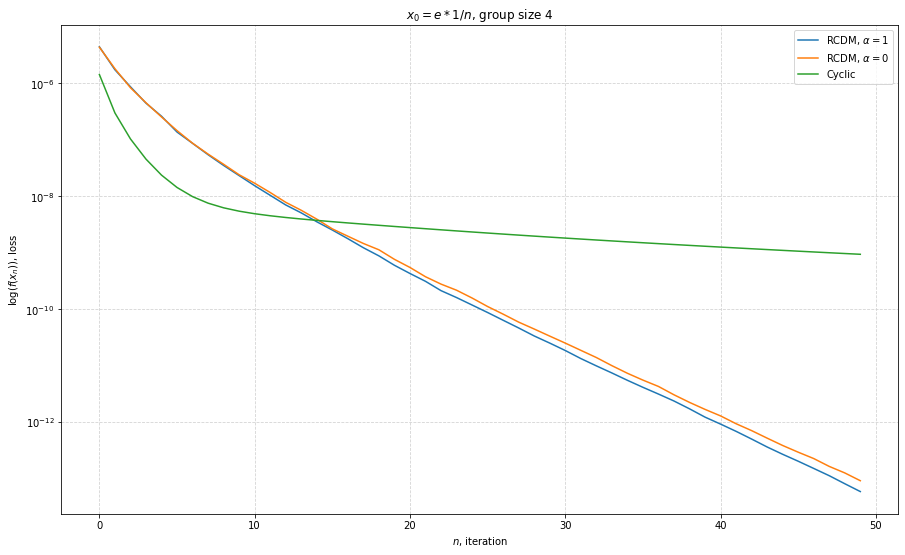

In [53]:
plt.figure(figsize=(15, 9))
plt.grid(color='lightgray',linestyle='--')
# title = r'$%s, \alpha = %d, x_0 = %s, n = %d$' % (log['strategy'], log['a'], log['x0'], log['n'])
plt.title(r'$x_0 = e * 1/n$, group size 4')
plt.xlabel(r'$n$, iteration')
plt.ylabel(r'$\log(f(x_n))$, loss')
plt.semilogy(urand_logs[n]['loss'][4][:50], label=r'RCDM, $\alpha = 1$')
plt.semilogy(uuni_logs[n]['loss'][4][:50], label=r'RCDM, $\alpha = 0$')
plt.semilogy(ucycl_logs[n]['loss'][4][:50], label=r'Cyclic')
plt.legend()

# x0 = 'r' if log['x0'] == 'random' else 'u'

# plt.hlines(1e-11, 0, 50, color = 'red', linestyle = '--')
plt.savefig('./pics/Triple_uniform.png');

In [5]:
# for i in [12, 16, 18]:
#     rand_logs[i] = run_experiment(pow_n = i, ignore_list=[2 ** j for j in range(4)])
#     cycl_logs[i] = run_experiment(pow_n = i, deter = True, ignore_list=[2 ** j for j in range(4)])

In [ ]:
for i in [12, 16, 18]:
    plot_results(rand_logs[i])

In [ ]:
for i in [12, 16, 18]:
    plot_results(cycl_logs[i])

In [31]:
# from tqdm import tqdm
nr_dict_groups = {}
for k in Ls.keys():
#     if k < 16:
#         continue
    indices = make_group(n, k)
    x0 = np.ones(n) / n
    
    max_iter = 200
    np.random.seed(0)
    nr_dict_groups[k] = run_iters(x0, indices, E_, gamma, L = Ls[k], max_iter = max_iter, deter=True)

100%|██████████| 200/200 [00:00<00:00, 2727.33it/s]


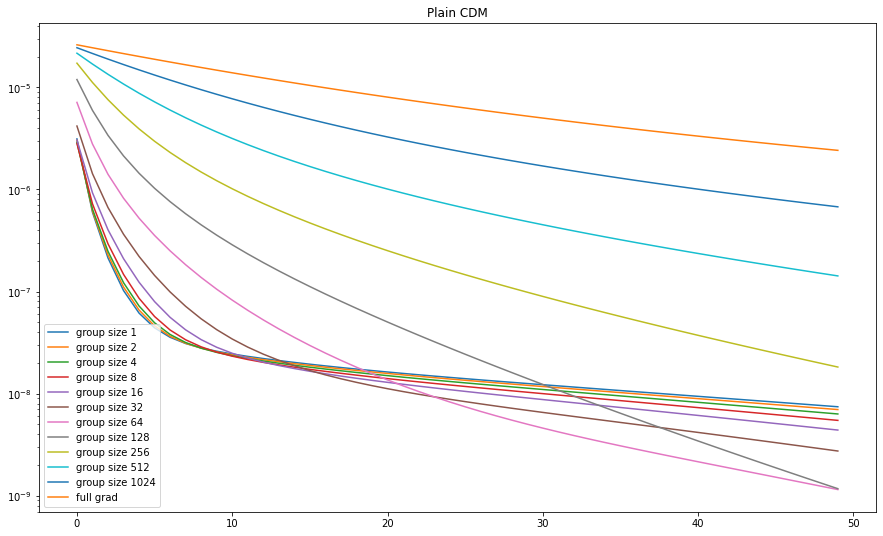

In [34]:
plt.figure(figsize=(15, 9))
plt.title(r'Plain CDM')
for k in nr_dict_groups.keys():
    plt.semilogy(nr_dict_groups[k][:50], label=f'group size {k}' if k != n else 'full grad')
# plt.plot(l, label='full grad')
plt.legend();

In [36]:
def dense_get_L(gr, E, gamma):
    '''
    E - NxN sparse matrix
    gamma - float
    gr - list (dict) of index lists
    '''
    res = []
    A = E - np.eye(len(E))
    for k in gr:
        Ak = (A.T[k] @ A[:, k])
        res.append(np.linalg.norm(Ak + gamma * np.ones((len(k),len(k))), ord = 2))
    return res

pow_n = 11
n = 2 ** pow_n
p = 10 / n
gamma = 1 / np.sqrt(n)

np.random.seed(0)
E = make_adjacency_mat(n, p = p, dtype=np.float32, column_stoch=True)
dense_Ls = {k : dense_get_L(make_group(n, k), E, gamma) for k in 2 ** np.arange(0, pow_n + 1, 1) }#if k < 2 or k > 32}
print(Ls.keys())

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048])


In [37]:
dense_dict_groups = {}
for k in Ls.keys():
#     if k < 16:
#         continue
    indices = make_group(n, k)
    x0 = np.ones(n) / n
    
    max_iter = 200
    np.random.seed(0)
    dense_dict_groups[k] = run_iters(x0, indices, E, gamma, L = dense_Ls[k], max_iter = max_iter, deter = True)

100%|██████████| 200/200 [00:04<00:00, 40.07it/s]


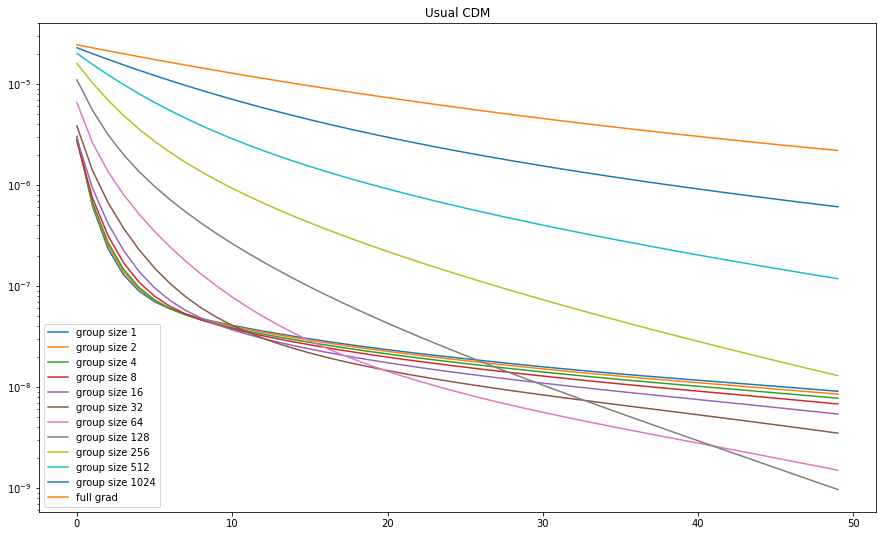

In [38]:
plt.figure(figsize=(15, 9))
plt.title(r'Usual CDM')
for k in dense_dict_groups.keys():
    plt.semilogy(dense_dict_groups[k][:50], label=f'group size {k}' if k != n else 'full grad')
# plt.plot(l, label='full grad')
plt.legend();